In [1]:
import pyqubo as pq
import numpy as np
import qubovert as qv
from neal import SimulatedAnnealingSampler

# Functions

In [2]:
def ConvertSolution(q, a, b):
    '''
    Vectorised function to convert an array of an array of qubits into an array of real numbers
    '''
    q = np.array(q)
    
    if len(np.shape(q))==1: # Backwards compatibility
        q = np.array([q])
        #return ConvertSolution_old(q,a,b)
    
    # Convert to binary
    shape = q.shape # shape
    powers = 2.**np.arange(0,-shape[-1],-1) # powers of 2 in descending
    chi = np.sum(q*powers,axis=1) # multiply in
    #print('.',chi)
    
    # Scale and shift
    gamma = (b - a)/2
    #print(gamma)
    x = gamma * chi + a
    
    return x

def H(M, y, R = 2, a = -1, b = 3):
    '''
    M and y come from problem Mx-y
    R is bit-precision, ie number of qubits
    a, b endpoints of desired range, a < b, [a,b)
    
    https://arxiv.org/pdf/1901.06526.pdf Section 3, eq 3.17-18
    ''' 
    
    # Save the dimension of problem as N
    N = np.shape(y)[0]

    # Define the midpoint of the range, hard coded atm
    gamma = (b - a)/2
    pho = gamma ** 2 # 🍜
    print('Precision:',(b-a)/2**R, f'Range: [{a},{b})')
    
    #Intialise Q as vector of zeros 
    Q = np.zeros((N * R, N * R))
    
    # Compute strengths
    MTM = M.T@M
    
    strengths = np.zeros_like(Q)
    for r in range(R):
        for s in range(R): # nb. includes r=s, which is used for weights
            block = pho * 2**(-r-s) * MTM
            ind_s = np.arange(N)*R + s
            ind_r = np.arange(N)*R + r
            strengths[np.ix_(ind_s, ind_r)] += np.copy(block)
    Q += np.copy(strengths)
        
    # Compute weights
    weights = np.zeros_like(Q)
    
    My = np.diag(M.T@y)
    sumMTM = np.diag(np.sum(MTM, axis=1))
    for r in range(R):
        ind_r = np.arange(N)*R + r
        block1 = 2*gamma *2**(-r) * -1 * My
        block2 = -a*2*gamma *2**(-r) * -1 * sumMTM
        weights[np.ix_(ind_r, ind_r)] += np.copy(block1) + np.copy(block2)
    Q += np.copy(weights)
    return Q

def anneal(A,B,accuracy,a,b, num_anneals=None):
    '''Outputs solution to Ax=B''' 
    # Err catch
    assert a<b, 'a needs to be less than b'

    # Calculation
    
    # Save the dimension of problem as N
    N = np.shape(B)[0]

    Q = H(A,B, R = accuracy, a = a, b = b) # Get Q
    Q_qubo = qv.utils.matrix_to_qubo(Q) # Convert to qubo
    
    if num_anneals == None:
        num_anneals = 100*N**accuracy
    
    state = qv.sim.anneal_qubo(Q_qubo, num_anneals = num_anneals) # Pass to anneal
    res = np.array(list(state.best.state.values())) # Result
    
    x = res.reshape((len(res)//accuracy,accuracy)) # Split result for each component
    sol = ConvertSolution(x,a,b) # Convert each component to decimal
    
    return sol

def test_anneal(dim, accuracy, a, b, seed, num_anneals=None):
    np.random.seed(seed)

    A = np.arange(dim**2).reshape((dim,dim))
    C = np.random.randint(b,size=dim)
    B = A@C
    sol = anneal(A,B,accuracy,a,b, num_anneals)
    
    print('Actual', C)
    print('Computed', sol)
    print('Error = ', np.linalg.norm(C-sol))
    return sol

# Test

In [3]:
# Paper example
A = np.array([[2,-1],[3,1]])
B = np.array([3,2]) #soln = 1,-1
sol = anneal(A,B,2,-1,3)
print(sol)

Precision: 1.0 Range: [-1,3)
[ 1. -1.]


In [4]:
# Different range
A = np.array([[2,-1],[3,1]])
B = np.array([3,2]) #soln = 1,-1
sol = anneal(A,B,5,-16,16)
print(sol)

Precision: 1.0 Range: [-16,16)
[ 1. -1.]


In [5]:
# Different solution
A = np.array([[2,-1],[3,1]])
C = np.array([10,-8]) 
B = A@C
sol = anneal(A,B,5,-16,16)
print(sol)

Precision: 1.0 Range: [-16,16)
[10. -8.]


In [6]:
# Different matrix
A = np.array([[np.e,np.pi],[18,420]])
C = np.array([6,9]) 
B = A@C
sol = anneal(A,B,5,-16,16)
print(sol)

Precision: 1.0 Range: [-16,16)
[6. 9.]


In [7]:
# Higher dim
dim = 3
b = 16
accuracy = 5
seed = 2

test_anneal(dim, accuracy, -b, b, seed)

Precision: 1.0 Range: [-16,16)
Actual [ 8 15 13]
Computed [10. 11. 15.]
Error =  4.898979485566356


array([10., 11., 15.])

In [8]:
# Higher dim
dim = 3
b = 4
accuracy = 3
seed = 6

test_anneal(dim, accuracy, -b, b, seed)

Precision: 1.0 Range: [-4,4)
Actual [2 1 3]
Computed [1. 3. 2.]
Error =  2.449489742783178


array([1., 3., 2.])

# Quantum Simulated Annealing

In [27]:
def q_anneal(A,B,accuracy,a,b, num_reads=None):
    '''Outputs solution to Ax=B''' 
    # Err catch
    assert a<b, 'a needs to be less than b'

    # Calculation
    
    # Save the dimension of problem as N
    N = np.shape(B)[0]

    Q = H(A,B, R = accuracy, a = a, b = b) # Get Q
    #Q_qubo = qv.utils.matrix_to_qubo(Q) # Convert to qubo
    
    
    if num_reads == None:
        num_reads = 9000

    res = np.array(list(SimulatedAnnealingSampler().sample_qubo(Q, num_reads=num_reads).first.sample.values()))

    x = res.reshape((len(res)//accuracy,accuracy)) # Split result for each component
    sol = ConvertSolution(x,a,b) # Convert each component to decimal
    
    return sol

def test_q_anneal(dim, accuracy, a, b, seed, num_reads=None):
    np.random.seed(seed)

    A = np.arange(dim**2).reshape((dim,dim))
    C = np.random.randint(b,size=dim)
    B = A@C
    sol = q_anneal(A,B,accuracy,a,b, num_reads)
    
    print('Actual', C)
    print('Computed', sol)
    print('Error = ', np.linalg.norm(C-sol))
    return sol

In [28]:
dim = 3
b = 4
accuracy = 3
seed = 60
test_q_anneal(dim, accuracy, -b, b, seed)

Precision: 1.0 Range: [-4,4)
[1 0 1 1 0 1 1 1 0]
Actual [1 1 2]
Computed [1. 1. 2.]
Error =  0.0


array([1., 1., 2.])

dim = 4
b = 4
accuracy = 3
seed = 60
test_q_anneal(dim, accuracy, -b, b, seed, num_reads = 400000)

# Matrix inversion

In [62]:
def invert_mat(A, accuracy, max_b, method=q_anneal):
    N = np.shape(A)[0]
    list_basis = list(np.eye(N))
    list_inverse = []
    for B in list_basis:
        x = method(A,B,accuracy,-max_b,max_b, num_reads=None)
        list_inverse.append(x)
    return np.array(list_inverse).T

In [64]:
dim = 2
A = np.arange(dim**2).reshape((dim,dim))
B = invert_mat(A,6,4)
print(B)
A@B

Precision: 0.125 Range: [-4,4)
[0 1 0 1 0 0 1 0 1 0 0 0]
Precision: 0.125 Range: [-4,4)
[1 0 0 1 0 0 1 0 0 0 0 0]
[[-1.5  0.5]
 [ 1.   0. ]]


array([[1., 0.],
       [0., 1.]])

# ODEs

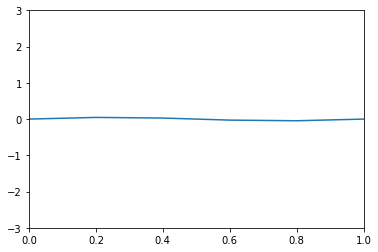

In [65]:
# From PDEs

'''
 This script finds a numerical approximation for the solution to
 the following 1D heat equation:
   u_t = u_xx  for  x \in (0,1),  t \in (0,T),
   u(x,t=0) = sin(2*pi*x) + 2*sin(5*pi*x),
   u(x=0,t) = u(x=1,t) = 0,
 using a backward Euler scheme.
''' 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation


## ====== setting parameters =======
# The grid spacing in the x-dimension
dx = 0.2;
# The x-dimension grid locations
x = np.arange(0, 1 + dx, dx)
# The number of x-dimension grid divisions
M = np.size(x)-1;
# The time step size
dt = 0.005;
# The time integration length
T = 0.1;
# The number of timesteps
N = int(np.floor(T/dt))

# Define the numerical solution 
# the first index is space and the second time
U = np.zeros((M+1,N+1))

# The initial condition
U[:,0] = np.sin(2*np.pi*x) + 2*np.sin(5*np.pi*x);
# enforcing the boundary condition
U[0,0] = 0 
U[-1,0] = 0 

# Form matrix which applies the backward Euler method
mu = dt/dx**2
A = np.diagflat((1+2*mu)*np.ones(M-1))+np.diagflat((-mu)*np.ones(M-2),1)+np.diagflat((-mu)*np.ones(M-2),-1)
Ainv = np.linalg.inv(A)

for n in range(N):
    # enforcing the boundary condition
    U[0,n+1] = 0 
    U[-1,n+1] = 0 
    # A single backward Euler timestep
    U[1:M,n+1] = np.dot(Ainv,U[1:M,n])
    

fig, ax = plt.subplots()
ax.axis([0,1,-3,3])
l, = ax.plot([],[])
def animate(i):
    l.set_data(x, U[:,i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=N)

from IPython.display import HTML
HTML(ani.to_jshtml())    

In [66]:
B = invert_mat(A,6,4)
print(B)
A@B

Precision: 0.125 Range: [-4,4)
[1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0]
Precision: 0.125 Range: [-4,4)
[1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
Precision: 0.125 Range: [-4,4)
[1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1]
Precision: 0.125 Range: [-4,4)
[1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1]
[[0.875 0.125 0.    0.   ]
 [0.125 0.875 0.125 0.   ]
 [0.    0.125 0.875 0.125]
 [0.    0.    0.125 0.875]]


array([[ 1.078125,  0.046875, -0.015625,  0.      ],
       [ 0.046875,  1.0625  ,  0.046875, -0.015625],
       [-0.015625,  0.046875,  1.0625  ,  0.046875],
       [ 0.      , -0.015625,  0.046875,  1.078125]])

In [46]:
dim = 10
b = 4
accuracy = 4
seed = 60
test_q_anneal(dim, accuracy, -b, b, seed)

Precision: 0.5 Range: [-4,4)
[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1
 1 1 0]
Actual [1 1 2 2 3 3 0 1 1 2]
Computed [ 3.5  3.5 -0.5  3.  -3.   1.   0.5  3.5  1.5  3. ]
Error =  8.215838362577491


array([ 3.5,  3.5, -0.5,  3. , -3. ,  1. ,  0.5,  3.5,  1.5,  3. ])

# Old Code

In [10]:
assert 0==1, 'autorun break'

AssertionError: autorun break

In [ ]:
def chi(precision, number):
    # number must be between 0 and 2
    q = np.zeros((number.size, precision))
    print(q)
    for i in range(len(number)):
        for r in range(precision):
            if number[i] < 2**(-r):
                q[i,r]=0
            else:
                q[i,r]=1
                number[i] -= 2**(-r)
    return q

test = np.array([.126,.6721,1.46])
chi(5, test)


In [ ]:
def ConvertSolution_old(q, a, b):
    '''
    Function to convert an array of qubits into a real number 
    '''
    
    # Store length of q vector
    n = np.shape(q)[0]
    
    # Initialise chi
    chi = 0
    
    for i in range(n):
        chi += (2 ** (-i)) * q[i]
    #print('.',chi)
    
    gamma = (b - a)/2
    x = gamma * chi - 1
    
    return x

def ConvertSolution(q, a, b):
    '''
    Vectorised function to convert an array of an array of qubits into an array of real numbers
    '''
    q = np.array(q)
    
    if len(np.shape(q))==1: # Backwards compatibility
        q = np.array([q])
        #return ConvertSolution_old(q,a,b)
    
    # Convert to binary
    shape = q.shape # shape
    powers = 2.**np.arange(0,-shape[-1],-1) # powers of 2 in descending
    chi = np.sum(q*powers,axis=1) # multiply in
    #print('.',chi)
    
    # Scale and shift
    gamma = (b - a)/2
    #print(gamma)
    x = gamma * chi + a
    
    return x

    
    
#ConvertSolution([0, 1, 1, 1, 1, 0, 1, 1, 0, 0], -1, 3)
print(ConvertSolution_old([1,1,1,0,1], -8, 8))
ConvertSolution([1,1,1,0,1], -8, 8)

In [ ]:


def H_old(M, y, R = 2, a = -1, b = 3):
    '''
    M and y come from problem Mx-y
    R is bit-precision, ie number of qubits
    a, b endpoints of desired range, a < b, [a,b)
    
    https://arxiv.org/pdf/1901.06526.pdf Section 3
    '''
    
    # Think I need Q to be upper triangular, how best to do this?
    # Need to add in the multiplication by pho 🍜 part as well!!
    
    
    # Save the dimension of problem as N
    N = np.shape(y)[0]

    # Define the midpoint of the range, hard coded atm
    gamma = (b - a)/2
    pho = gamma ** 2
    #print(gamma,pho)
    print('Precision:',(b-a)/2**R)
    
    #Intialise Q as vector of zeros 
    Q = np.zeros((N * R, N * R))
    
    # First term 
    for i in range(N):
        #print(f'i is {i}')
        for r in range(R):
            #print(f'r is {r}')
            for j in range(N):
                # print(f'j is {j}')
                for s in range(R):
                    # print(f's is {s}')
                    for k in range(N):
                        # print(f'k is {k}')
                        
                        # Update relevant entry of Q
                        Q[i * R + r,j * R + s] += (2 ** (-r-s)) * M[k,i] * M[k,j] * pho
                        
                        
    # Second term
    # Loop over each number 
    for i in range(N):
        # Loop over each qubit encoding said number
        for r in range(R):
            # Loop of k for matrix multiplication in index form
            for k in range(N):
                Q[i * R + r, i * R + r] += (2 ** (-r)) * M[k,i] * M[k,i] * -2 * gamma 
                
    # Third term
    # Loop over each number
    for i in range(N):
        # Loop over j for the matrix multiplication
        for j in range(N):
            # Loop over each qubit encoding the number
            for r in range(R):
                Q[i * R + r, i * R + r] +=  (2 ** (-r)) * M[j,i] * y[j]  * -2 * gamma 
                
                
#     # Fourth term (necessary?)
#     for i in range(N):
#         for j in range(N):
#             Q
    
    # Make Q upper triangular
    return Q+np.triu(Q)-np.tril(Q)

A = np.array([[2,-1],[3,1]])
B = np.array([3,2]) #soln = 1,-1


a_test = -16
b_test = 32+a_test # b-a needs to be power of 2
accuracy = 5
Q = H_old(A,B, R = accuracy, a = a_test, b = b_test)
Q_qubo = qv.utils.matrix_to_qubo(Q)
print(Q)
#Q_qubo.solve_bruteforce()

state = qv.sim.anneal_qubo(Q_qubo, num_anneals = 100*2**accuracy)
res = list(state.best.state.values())
print(res)
x1 = res[:accuracy]
x2 = res[accuracy:accuracy*2]
print(x1,x2)
print(ConvertSolution(x1,a_test,b_test))
print(ConvertSolution(x2,a_test,b_test))

In [ ]:
def anneal(A,B,accuracy,a,b):
    '''Outputs solution to Ax=b''' 
    # Err catch
    assert a<b, 'a needs to be less than b'

    # Calculation
    Q = H(A,B, R = accuracy, a = a, b = b) # Get Q
    Q_qubo = qv.utils.matrix_to_qubo(Q) # Convert to qubo
    state = qv.sim.anneal_qubo(Q_qubo, num_anneals = 100*2**accuracy) # Pass to anneal
    res = np.array(list(state.best.state.values())) # Result
    x = res.reshape((len(res)//accuracy,accuracy)) # Split result for each component
    print(x)
    sol = ConvertSolution(x,a,b) # Convert each component to decimal
    return sol


A = np.array([[2,-1],[3,1]])
B = np.array([3,2]) #soln = 1,-1
sol = anneal(A,B,5,-16,16)
print(sol)

In [ ]:
A = np.array([[2,-1],[3,1]])
A = np.eye(2)
C = np.array([2,-2]) 
B = A@C
sol = anneal(A,B,5,-16,16)
print(sol)

In [ ]:
# assert 1==0, 'dont run below'

def H(M, y, R = 2, a = -1, b = 3):
    '''
    M and y come from problem Mx-y
    R is bit-precision, ie number of qubits
    a, b endpoints of desired range, a < b, [a,b)
    
    https://arxiv.org/pdf/1901.06526.pdf Section 3, eq 3.17-18
    ''' 
    
    # Save the dimension of problem as N
    N = np.shape(y)[0]

    # Define the midpoint of the range, hard coded atm
    gamma = (b - a)/2
    pho = gamma ** 2 # 🍜
    print(gamma,pho)
    print('Precision:',(b-a)/2**R, f'Range: [{a},{b})')
    
    #Intialise Q as vector of zeros 
    Q = np.zeros((N * R, N * R))
    
    # Compute strengths
    MTM = M.T@M
    
    strengths = np.zeros_like(Q)
    for r in range(R):
        for s in range(R): # nb. includes r=s, which is used for weights
            block = pho * 2**(-r-s) * MTM
            ind_s = np.arange(N)*R + s
            ind_r = np.arange(N)*R + r
            strengths[np.ix_(ind_s, ind_r)] += np.copy(block)
    Q += np.copy(strengths)
    
    
    # Compute weights
    weights = np.zeros_like(Q)
    
    My = np.diag(M.T@y)
    sumMTM = np.diag(np.sum(MTM, axis=1))
    for r in range(R):
        ind_r = np.arange(N)*R + r
        block1 = 2*gamma *2**(-r) * -1 * My
        block2 = -a*2*gamma *2**(-r) * -1 * sumMTM
        weights[np.ix_(ind_r, ind_r)] += np.copy(block1) + np.copy(block2)
    Q += np.copy(weights)
    return Q

A = np.array([[2,-1],[3,1]])
#A = np.eye(2)
C = np.array([4,-8]) 
B = A@C

a=-16
b=16
R=4

sol = anneal(A,B,R,a,b)
print(sol)


In [ ]:
Q = H_old(A,B, R,a,b)
print(Q)
Q_qubo = qv.utils.matrix_to_qubo(Q)

state = qv.sim.anneal_qubo(Q_qubo, num_anneals = 100*2**accuracy)
res = list(state.best.state.values())
print(res)
x1 = res[:4]
x2 = res[4:]
print(x1,x2)
print(ConvertSolution(x1,a,b))
print(ConvertSolution(x2,a,b))

In [ ]:
a_test = -16
b_test = 32+a_test # b-a needs to be power of 2
accuracy = 5
Q = H(A,B, R = accuracy, a = a_test, b = b_test)
Q_qubo = qv.utils.matrix_to_qubo(Q)
#print(Q)
#Q_qubo.solve_bruteforce()

state = qv.sim.anneal_qubo(Q_qubo, num_anneals = 100*2**accuracy)
res = list(state.best.state.values())
print(res)
x1 = res[:accuracy]
x2 = res[accuracy:accuracy*2]
print(x1,x2)
print(ConvertSolution_old(x1,a_test,b_test))
print(ConvertSolution_old(x2,a_test,b_test))

In [ ]:

    
    
    
#     strengths = np.empty((N*R, N*R))
#     for r in range(R):
#         sub_block = np.empty((R, R))
#         if r>0:
#             sub_block = np.concatenate([sub_block, np.zeros((R,R*r))], axis=1)
#         for s in range(R):
#             block = 4 * 2**(-r-s) * MTM
#             print(sub_block,'\n')
#             sub_block = np.concatenate([sub_block, block], axis=1)
#         print(strengths,'\n')
#         strengths = np.concatenate([sub_block, block], axis=0)
#     print(strengths)
    
    

In [ ]:
A = np.array([[2, -1], [3, 1]])
b = np.array([3,2])

Q = H(2,2, A, b)
print(Q)

qubo = qv.utils.matrix_to_qubo(Q)1
print(qubo.pretty_str())

qubo.solve_bruteforce()

res = qv.sim.anneal_qubo(qv.utils.matrix_to_qubo(Q), num_anneals=10)

print(res.best)

In [ ]:
A = np.array([[-7, -2], [6, 3]])
b = np.array([-4,-5])

Q = get_Q(3,2, A, b)
print(Q)
qubo = qv.utils.matrix_to_qubo(Q)
print(qubo.pretty_str())

print(qubo.solve_bruteforce())

res = qv.sim.anneal_qubo(qv.utils.matrix_to_qubo(Q), num_anneals=10)

print(res.best)